In [1]:
import sys
sys.path.append('..')
from hamp_pred.src.predictor import Predictor
from hamp_pred.src.predictor_config import DEFAULT_CONF, PredictionConfig,SEQ_ENCODING_EXTERNAL
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from Bio import SeqIO
import tensorflow as tf
from hamp_pred.external.SequenceEncoding.SequenceEncoding import SequenceEncoding, get_dict
from hamp_pred.src.input_prep.encode import OneHotEncoderSeq, RadianEncoder, MixedEncoder, MultiEncoder
from hamp_pred.src.input_prep.prepare_sequence import MultiChainOperator, SeqWindow
from hamp_pred.src.models.common.models import BaseConvolutionalWrapper, BaseLinearWrapper
from hamp_pred.src.input_prep.encode import RadiousPhobosEncoder
from hamp_pred.src.output_analysis.visual import reg_plot
from keras.utils.vis_utils import plot_model
from Bio.PDB.PDBParser import PDBParser
import os
import matplotlib.pyplot as plt

## Train full seq model

In [2]:
data = pd.read_pickle('../data/input/full_alpha_data.p')
val_ids = set(data[data['class'] == 'val'].index)
idx = list(data.index)
operator = MultiChainOperator(MultiEncoder([RadiousPhobosEncoder(), OneHotEncoderSeq()]), SeqWindow(60, 60), RadianEncoder(100),  SeqWindow(60, 60, null_char=[[0]]),
                                      parallel=True, n_chains=1, chain_names=('seq', ))
model_conf = model_config = {
    'activation': 'linear',
    'norm': True,
    'n_layers': 3,
    'kernel_sizes': (3, 5, 7),
    'lstm': 2,
    'dense': 3,
    'reshape_out': False,
    'epochs': 300
}
conf = PredictionConfig(BaseConvolutionalWrapper, operator, model_conf)
pred = Predictor('hamp_crick_ensemble', config=conf)
# trained = pred.train(data)

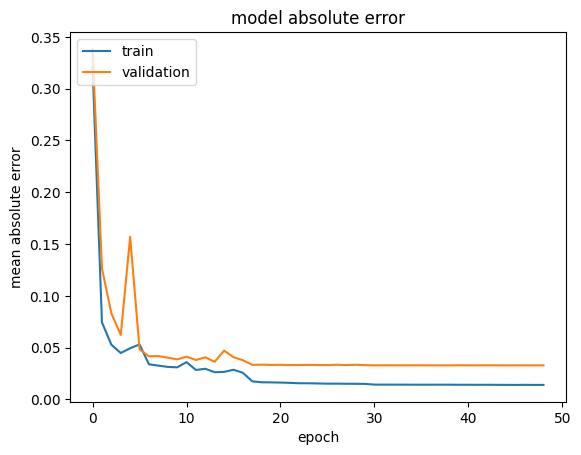

In [4]:
plt.plot(trained.history.history['mae'])
plt.plot(trained.history.history['val_mae'])
plt.title('model absolute error')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

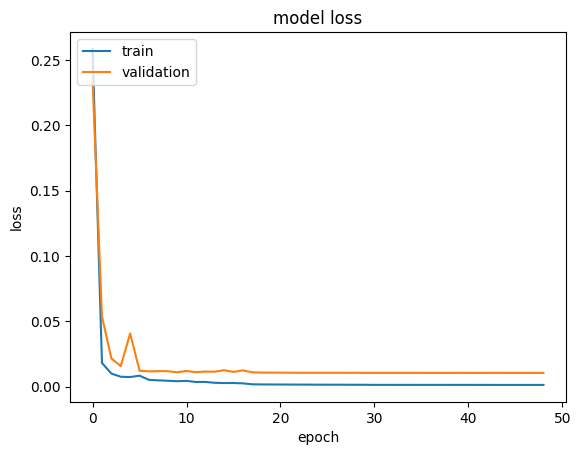

In [5]:
plt.plot(trained.history.history['loss'])
plt.plot(trained.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Alpha fold test set results

In [3]:
DATA_DIR = '../data/input'
val = f'{DATA_DIR}/af_clean_model_full_test.p'
val = pd.read_pickle(val)
seqs = list(val.full_sequence)

In [4]:
alpha_test_results = pred.predict(val, is_test=True)
print(f"RMSE_SEQ: {alpha_test_results['mse_seq']**0.5}\nRMSE_POS: {alpha_test_results['mse_pos']**0.5}")

2023-04-07 16:00:29.251604: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1/1 [==============================] - 2s 2s/step


/Users/awinski/PycharmProjects/HAMPpred/hamp_pred/src/input_prep/encode.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([np.array(x) for x in labels])
/Users/awinski/PycharmProjects/HAMPpred/hamp_pred/src/input_prep/encode.py:184: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ret = np.asarray(res)


1/1 [==============================] - 2s 2s/step


/Users/awinski/PycharmProjects/HAMPpred/hamp_pred/src/input_prep/encode.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([np.array(x) for x in labels])
/Users/awinski/PycharmProjects/HAMPpred/hamp_pred/src/input_prep/encode.py:184: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ret = np.asarray(res)


RMSE_SEQ: 18.94079472212853
RMSE_POS: 22.01660430374009


/Users/awinski/PycharmProjects/HAMPpred/hamp_pred/src/input_prep/encode.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([np.array(x) for x in labels])
/Users/awinski/PycharmProjects/HAMPpred/hamp_pred/src/input_prep/encode.py:184: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ret = np.asarray(res)


<AxesSubplot: title={'center': 'Predictions for data set'}, xlabel='Predicted', ylabel='True'>

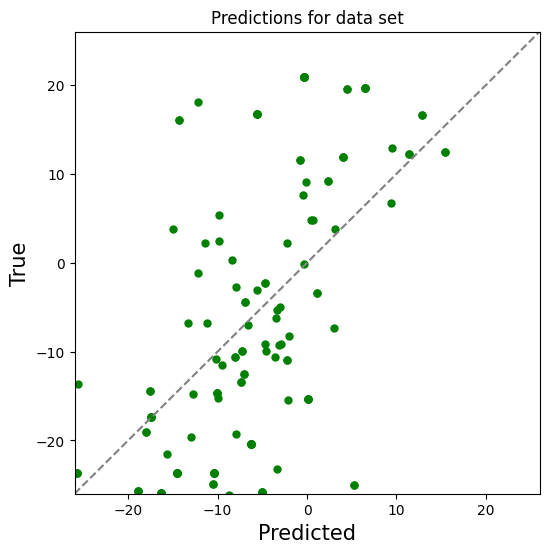

In [5]:
reg_plot(alpha_test_results['true_mean_rot'], alpha_test_results['pred_mean_rot'])

## Test on PDB

In [7]:
val = f'{DATA_DIR}/full_pdb_hamp.p'
val = pd.read_pickle(val)
seqs = list(val.full_sequence)
pdb_test_results = pred.predict(val, is_test=True)

1/1 [==============================] - 1s 1s/step


/Users/awinski/PycharmProjects/HAMPpred/hamp_pred/src/input_prep/encode.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([np.array(x) for x in labels])
/Users/awinski/PycharmProjects/HAMPpred/hamp_pred/src/input_prep/encode.py:184: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ret = np.asarray(res)


1/1 [==============================] - 1s 1s/step


/Users/awinski/PycharmProjects/HAMPpred/hamp_pred/src/input_prep/encode.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([np.array(x) for x in labels])
/Users/awinski/PycharmProjects/HAMPpred/hamp_pred/src/input_prep/encode.py:184: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ret = np.asarray(res)
/Users/awinski/PycharmProjects/HAMPpred/hamp_pred/src/input_prep/encode.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths o

<AxesSubplot: title={'center': 'Prediction for HAMPs'}, xlabel='Predicted', ylabel='PDB Structure'>

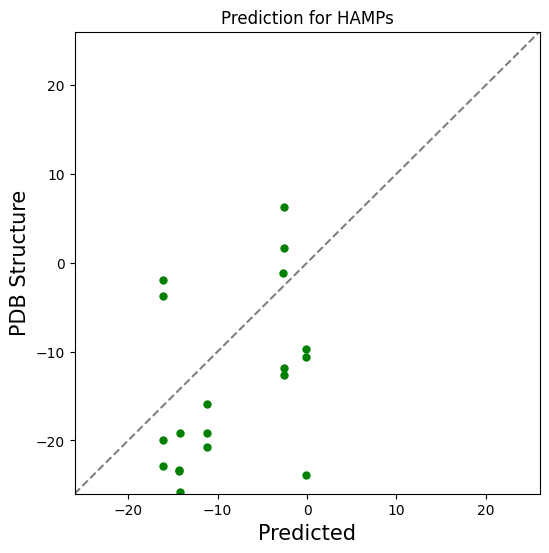

In [8]:
reg_plot(pdb_test_results['true_mean_rot'], pdb_test_results['pred_mean_rot'], title='Prediction for HAMPs', ylabel='PDB Structure')